# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 7th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [28]:
# Change here using YOUR first and last names
fn1 = "Yu"
ln1 = "Xiang"
fn2 = "Jean"
ln2 = "Babin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_xiang_yu_and_babin_jean.ipynb


In [29]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [30]:
import numpy as np
import matplotlib.pyplot as plt
norm = np.linalg.norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

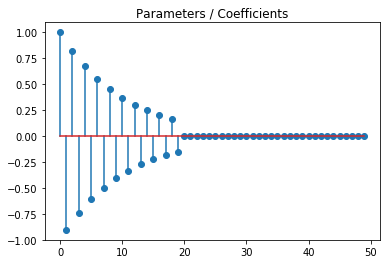

In [31]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")


### Functions for the simulation of the models

In [32]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # multivariate_normal:  Draw random samples from a multivariate normal distribution
    
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a function $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [33]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""  
    """s is the regularation parameter"""
    # x is the observation
    return np.sign(x) * np.maximum(np.abs(x) - s, 0)   
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""    
    return s * norm(x, ord=1)

def prox_ridge(x, s):
    """Proximal operator for the ridge at x"""   
    return x / (1. + s)
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    return s / 2. * norm(x) ** 2.

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

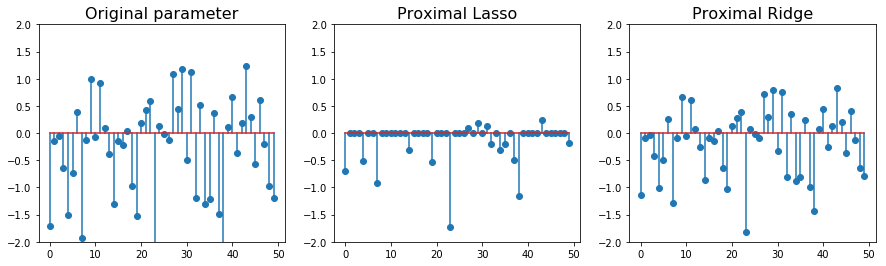

In [34]:
x = randn(50) # 50 random numbers from the “standard normal” distribution
l_l1 = 1.     # regularation parameter for Lasso
l_l2 = 0.5    # regularation parameter for Ridge

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])

plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])

plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])
plt.show()


<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

The original parameters are 50 random numbers from the “standard normal” distribution. 

The proximity operator for Lasso has the effect to regularize the parameter, when the absolute value of the original parameter is smaller than the regularation parameter $s$ (where $s = 1$ in this case), the parameter is reduced to the zero, and when the absolute value of the original parameter is bigger than $s$, its absolute value is reduced by $s$, with the sign unchanged. 

For the proximity operator for Ridge, the orignal parameter is divided by $(1. + s)$, where $s = 0.5$ in this case.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [35]:
def loss_linreg(x):
    """ Least-squares loss"""
    """
    # A: matrix of features
    # b: b=[b1⋯bn]is the vector of labels
    # x: observations
    
    """
    return 1. / (2. * n_samples) * norm(A_lr.dot(x) - b_lr) ** 2.


def grad_linreg(x):
    """Leas-squares gradient"""

    return 1. / n_samples *  A_lr.T.dot(A_lr).dot(x) - 1. / n_samples * b_lr.T.dot(A_lr)


def loss_logreg(x):
    """Logistic loss"""
    """
    # A: matrix of features, size n * n
    # b:  labels,  bi∈{−1,1} for all i.
    # x: observations, len = n (n*1)  
    """
    
    return np.sum(1. / n_samples * np.log(1. + np.exp(-b_log * A_log.dot(x))))
    

def grad_logreg(x):
    """Logistic gradient"""
    
    bAT = np.multiply(A_log, b_log[:, np.newaxis])
    sigmoid_part =  1. / (1. + np.exp(bAT.dot(x)))
    return np.sum(1. / n_samples * np.multiply(-bAT, sigmoid_part[:, np.newaxis]), axis=0)


In [36]:
"""Check that these functions are correct by numerically checking the gradient"""

# check function gradient
import scipy.optimize as optimize
ck_grad = optimize.check_grad

## check for linear regression
coefs_lr = coefs[:]
x_lr = x[:]
A_lr, b_lr = simu_linreg(coefs)

# check the function works
loss_linreg(x_lr)
grad_linreg(x_lr)
# check the gradient
linear_ck_grad = ck_grad(loss_linreg, grad_linreg, x_lr)
print ('Square root of the sum of square of the differences for linear regression: ', "%.3E" % linear_ck_grad)


## check for log regression
x_log = x[:]
coefs_log = coefs[:]
A_log, b_log = simu_logreg(coefs_log)

# check the functions
sum_f = loss_logreg(x_log)
sum_df = grad_logreg(x_log)
log_ck_grads = ck_grad(loss_logreg, grad_logreg, x_log)

print ('Square root of the sum of square of the differences for log regression: ', "%.3E" % log_ck_grads)

Square root of the sum of square of the differences for linear regression:  3.003E-06
Square root of the sum of square of the differences for log regression:  1.986E-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [37]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    """ # f(x) second order derivative  = 1 / n * A.T * A  """
    
    return norm(A, ord=2) ** 2. / n_samples
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""
    
    return norm(A, ord=2) ** 2. / 4.
       
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    
    x = x0.copy()
    x_new = x0.copy()

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
                    
    for k in range(n_iter + 1):        
         
        x = prox_g(x - step * grad_f(x), s)       
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
     
        if k % 100 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [38]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    # n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.   
    
    beta = 1
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
             
        xplus = prox_g(z - step * grad_f(z), s)
        betaplus = (1. + (1. + 4. * beta ** 2.) ** 0.5) / 2.
        z = xplus + (beta - 1.) / betaplus * (xplus - x)
        x = xplus
        beta = betaplus       

        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)

        if k % 100 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

In [39]:
""" Compute a precise minimum and a precise minimizer """

# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 30000
A_lr, b_lr = simu_linreg(coefs)
L = lip_linreg(A_lr)
s = 1e-2
step = s / L
f = loss_linreg
grad_f = grad_linreg
g = ridge
prox_g = prox_ridge

fista_x, fista_objectives, fista_errors = fista(x0, f, grad_f, g, prox_g, step, s, n_iter,
         x_true=coefs, verbose=True)

print ("\n")
# Use the same setting of fista to call ista again
ista_x, ista_objectives, ista_errors = ista(x0, f, grad_f, g, prox_g, step, s, n_iter,
         x_true=coefs, verbose=True)

print ("\n")
print ('The precise minimum is: ',  fista_objectives[-1])
print ('The precise minimizer is: ',  fista_x)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.59e+00 | 9.99e-01
     100 | 1.32e+00 | 8.90e-01
     200 | 1.33e+00 | 8.92e-01
     300 | 1.32e+00 | 8.92e-01
     400 | 1.32e+00 | 8.92e-01
     500 | 1.32e+00 | 8.92e-01
     600 | 1.32e+00 | 8.92e-01
     700 | 1.32e+00 | 8.92e-01
     800 | 1.32e+00 | 8.92e-01
     900 | 1.32e+00 | 8.92e-01
    1000 | 1.32e+00 | 8.92e-01
    1100 | 1.32e+00 | 8.92e-01
    1200 | 1.32e+00 | 8.92e-01
    1300 | 1.32e+00 | 8.92e-01
    1400 | 1.32e+00 | 8.92e-01
    1500 | 1.32e+00 | 8.92e-01
    1600 | 1.32e+00 | 8.92e-01
    1700 | 1.32e+00 | 8.92e-01
    1800 | 1.32e+00 | 8.92e-01
    1900 | 1.32e+00 | 8.92e-01
    2000 | 1.32e+00 | 8.92e-01
    2100 | 1.32e+00 | 8.92e-01
    2200 | 1.32e+00 | 8.92e-01
    2300 | 1.32e+00 | 8.92e-01
    2400 | 1.32e+00 | 8.92e-01
    2500 | 1.32e+00 | 8.92e-01
    2600 | 1.32e+00 | 8.92e-01
    2700 | 1.32e+00 | 8.92e-01
    2800 | 1.32e+00 | 8.92e-01
    2900 | 1.32e+00 | 8.92e-01
    3000 | 1.3

   26500 | 1.32e+00 | 8.92e-01
   26600 | 1.32e+00 | 8.92e-01
   26700 | 1.32e+00 | 8.92e-01
   26800 | 1.32e+00 | 8.92e-01
   26900 | 1.32e+00 | 8.92e-01
   27000 | 1.32e+00 | 8.92e-01
   27100 | 1.32e+00 | 8.92e-01
   27200 | 1.32e+00 | 8.92e-01
   27300 | 1.32e+00 | 8.92e-01
   27400 | 1.32e+00 | 8.92e-01
   27500 | 1.32e+00 | 8.92e-01
   27600 | 1.32e+00 | 8.92e-01
   27700 | 1.32e+00 | 8.92e-01
   27800 | 1.32e+00 | 8.92e-01
   27900 | 1.32e+00 | 8.92e-01
   28000 | 1.32e+00 | 8.92e-01
   28100 | 1.32e+00 | 8.92e-01
   28200 | 1.32e+00 | 8.92e-01
   28300 | 1.32e+00 | 8.92e-01
   28400 | 1.32e+00 | 8.92e-01
   28500 | 1.32e+00 | 8.92e-01
   28600 | 1.32e+00 | 8.92e-01
   28700 | 1.32e+00 | 8.92e-01
   28800 | 1.32e+00 | 8.92e-01
   28900 | 1.32e+00 | 8.92e-01
   29000 | 1.32e+00 | 8.92e-01
   29100 | 1.32e+00 | 8.92e-01
   29200 | 1.32e+00 | 8.92e-01
   29300 | 1.32e+00 | 8.92e-01
   29400 | 1.32e+00 | 8.92e-01
   29500 | 1.32e+00 | 8.92e-01
   29600 | 1.32e+00 | 8.92e-01
   29700

   23100 | 1.32e+00 | 8.92e-01
   23200 | 1.32e+00 | 8.92e-01
   23300 | 1.32e+00 | 8.92e-01
   23400 | 1.32e+00 | 8.92e-01
   23500 | 1.32e+00 | 8.92e-01
   23600 | 1.32e+00 | 8.92e-01
   23700 | 1.32e+00 | 8.92e-01
   23800 | 1.32e+00 | 8.92e-01
   23900 | 1.32e+00 | 8.92e-01
   24000 | 1.32e+00 | 8.92e-01
   24100 | 1.32e+00 | 8.92e-01
   24200 | 1.32e+00 | 8.92e-01
   24300 | 1.32e+00 | 8.92e-01
   24400 | 1.32e+00 | 8.92e-01
   24500 | 1.32e+00 | 8.92e-01
   24600 | 1.32e+00 | 8.92e-01
   24700 | 1.32e+00 | 8.92e-01
   24800 | 1.32e+00 | 8.92e-01
   24900 | 1.32e+00 | 8.92e-01
   25000 | 1.32e+00 | 8.92e-01
   25100 | 1.32e+00 | 8.92e-01
   25200 | 1.32e+00 | 8.92e-01
   25300 | 1.32e+00 | 8.92e-01
   25400 | 1.32e+00 | 8.92e-01
   25500 | 1.32e+00 | 8.92e-01
   25600 | 1.32e+00 | 8.92e-01
   25700 | 1.32e+00 | 8.92e-01
   25800 | 1.32e+00 | 8.92e-01
   25900 | 1.32e+00 | 8.92e-01
   26000 | 1.32e+00 | 8.92e-01
   26100 | 1.32e+00 | 8.92e-01
   26200 | 1.32e+00 | 8.92e-01
   26300

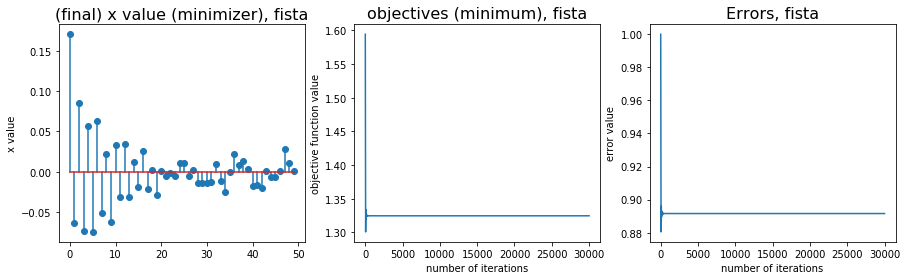

In [40]:
""" display the result with fista method"""
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(fista_x)
plt.ylabel('x value')
plt.title("(final) x value (minimizer), fista", fontsize=16)

plt.subplot(1, 3, 2)
plt.plot(fista_objectives)
plt.xlabel('number of iterations')
plt.ylabel('objective function value')
plt.title("objectives (minimum), fista", fontsize=16)

plt.subplot(1, 3, 3)
plt.plot(fista_errors)
plt.xlabel('number of iterations')
plt.ylabel('error value')
plt.title("Errors, fista", fontsize=16)
plt.show()



Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.
    


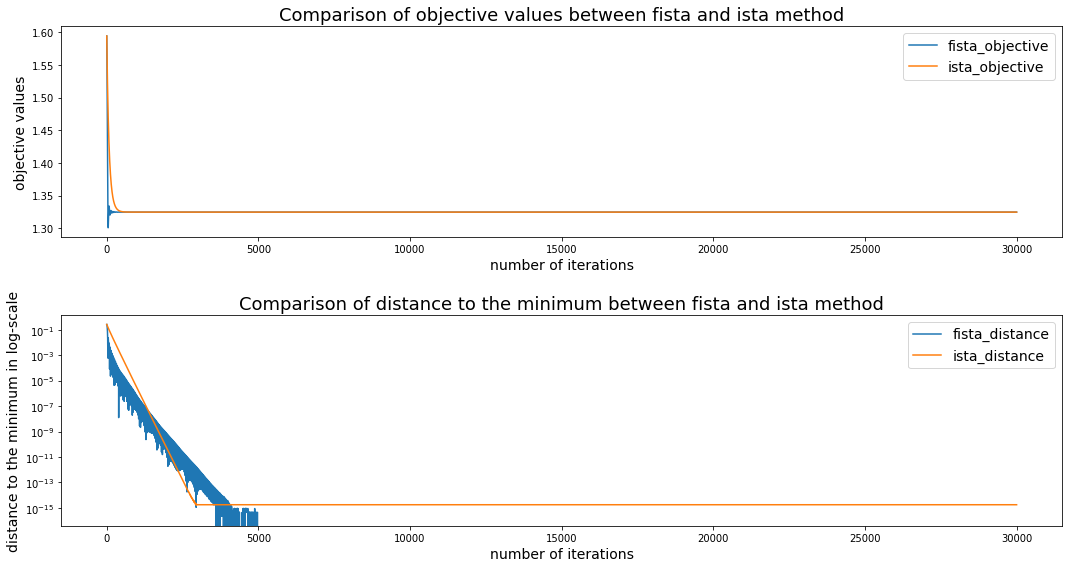

In [41]:
""" Compare the convergences of ISTA and FISTA """

iteration_ids = np.arange(0, n_iter + 2)
plt.figure(figsize=(15., 8.))
plt.subplot(2, 1, 1)
plt.plot(iteration_ids, fista_objectives, label='fista_objective')
plt.plot(iteration_ids, ista_objectives, label='ista_objective')
plt.xlabel('number of iterations', fontsize=14)
plt.ylabel('objective values',fontsize=14)
plt.legend(loc=1, fontsize=14)
plt.title('Comparison of objective values between fista and ista method',fontsize=18)


minimun_f = fista_objectives[-1]

# compare the convergences of ISTA and FISTA in terms of distance to the minimum 
fista_dis_minimum = (np.abs(fista_objectives - minimun_f) ** 2.) ** (1./2)
ista_dis_minimum = (np.abs(ista_objectives - minimun_f) ** 2.) ** (1./2) 

plt.subplot(2, 1, 2)
plt.semilogy(iteration_ids, fista_dis_minimum, label="fista_distance")
plt.semilogy(iteration_ids, ista_dis_minimum, label="ista_distance")
plt.xlabel('number of iterations', fontsize=14)
plt.ylabel('distance to the minimum in log-scale', fontsize=14)
plt.legend(loc=1, fontsize=14)
plt.title('Comparison of distance to the minimum between fista and ista method', fontsize=18)

plt.tight_layout()
plt.show()


Fista coverges to the solution much faster than the ista method. 
### Question to the TA: should the distance to the minimizer be considered? if yes, then in each step, the x value should be stored in fista and ista function

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    </ul>
</div>
This will be reffered as Q0

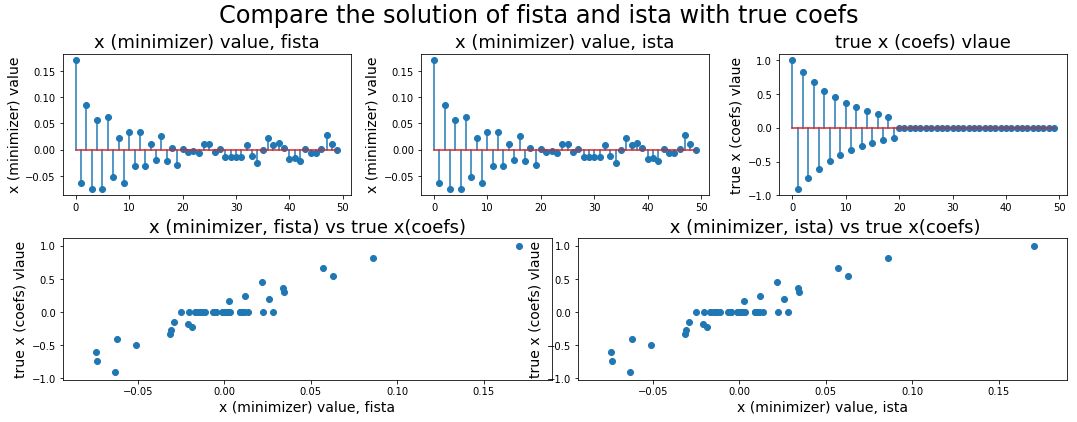

The error between fista_x and ista_x: 
 [ 2.78e-15 -1.39e-15  0.00e+00  0.00e+00 -8.33e-17  0.00e+00  1.24e-15
 -6.94e-16  0.00e+00 -6.94e-16  6.94e-16  0.00e+00  0.00e+00 -1.67e-16
  5.90e-17  0.00e+00  0.00e+00  0.00e+00  4.34e-17  0.00e+00 -2.10e-17
  0.00e+00  0.00e+00  0.00e+00 -1.73e-16  0.00e+00  8.67e-17 -4.34e-17
  1.73e-16 -1.73e-16  0.00e+00  1.39e-16 -6.94e-17  1.30e-16  0.00e+00
  3.71e-17 -3.47e-16  6.94e-17  0.00e+00 -2.21e-17  2.74e-16  5.90e-17
 -3.40e-16  3.25e-17  0.00e+00  0.00e+00 -2.17e-17 -2.08e-17  0.00e+00
 -2.17e-19]


In [42]:
#******************************** Q0 *************************
""" Compare the solution of fista and ista with true coefs """

fig = plt.figure(figsize=(18., 6.))
grid = plt.GridSpec(2, 90, wspace=0.4, hspace=0.3)

plt.subplot(grid[0, 0:26])
plt.stem(fista_x)
plt.ylabel('x (minimizer) value',  fontsize=14)
plt.title('x (minimizer) value, fista', fontsize=18)
plt.subplot(grid[0, 32:58])
plt.stem(ista_x)
plt.ylabel('x (minimizer) value',  fontsize=14)
plt.title('x (minimizer) value, ista', fontsize=18)

plt.subplot(grid[0, 64:90])
plt.stem(coefs)
plt.ylabel('true x (coefs) vlaue', fontsize=14)
plt.title('true x (coefs) vlaue', fontsize=18)

plt.subplot(grid[1, 0:44])
plt.scatter(fista_x,coefs)
plt.xlabel('x (minimizer) value, fista', fontsize=14)
plt.ylabel('true x (coefs) vlaue', fontsize=14)
plt.title('x (minimizer, fista) vs true x(coefs)', fontsize=18)

plt.subplot(grid[1, 46:90])
plt.scatter(ista_x,coefs)
plt.xlabel('x (minimizer) value, ista', fontsize=14)
plt.ylabel('true x (coefs) vlaue', fontsize=14)
plt.title(' x (minimizer, ista) vs true x(coefs)', fontsize=18)
fig.get_axes()[0].annotate('Compare the solution of fista and ista with true coefs',
                           (0.5, 0.945), xycoords='figure fraction', ha='center', 
                            fontsize=24 )
plt.show()


print ('The error between fista_x and ista_x: \n', fista_x - ista_x)

Compared to the true value, the minimizer is much smaller on absolute level for those whose true values are large, and the minimizer almost does not reach zero for those whose true values are zero. The fista and ista method return almost the same x_value (minimizer). 

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
</div>
This will be referred as Q1

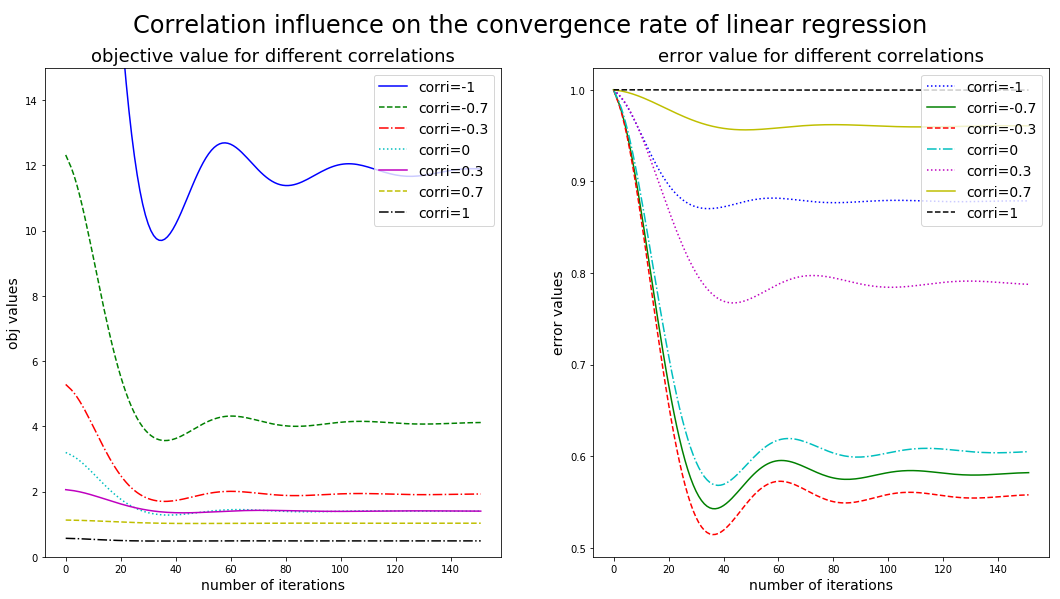

In [43]:
# In linear regression and logistic regression, study the influence of the correlation of the features
# on the performance of the optimization algorithms. Explain.
#******************* Q1 ***********************************************

"""  We first check the influence on the linear regression:  Part 1 """
"""  Then we check the influence on the logistic regression: Part 2 """
"""  Finally, we comment and explain the result! :           Part 3 """


"""Part 1: correlation influence on the linear regresison (with fista method)"""

from itertools import cycle
import itertools
lines = ["-","--","-.",":"]
linecycler = cycle(lines)
colors = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

# we test the correlation with seven differnt values
correlations = [-1, -0.7, -0.3, 0, 0.3, 0.7, 1]

# the settings are the same as above, only the number of iterations is reduced to 150
x0 = np.zeros(n_features)
n_iter = 150
s = 1e-2
f = loss_linreg
grad_f = grad_linreg
g = ridge
prox_g = prox_ridge

iteration_ids = np.arange(0, n_iter + 2)
nr_corrs = len(correlations)
nr_f_obj = len(iteration_ids)
f_obj = np.zeros(shape=(nr_f_obj,nr_corrs))
xs = np.zeros((n_features, nr_corrs))
errors = np.zeros((nr_f_obj, nr_corrs))

### calculate new results with different correlations
for i in range(nr_corrs):
    corri = correlations[i]
    A_lr, b_lr = simu_linreg(coefs, corr=corri)
    L = lip_linreg(A_lr)
    step = s / L
    fista_x, fista_objectives, fista_errors = fista(x0, f, grad_f, g, prox_g, step, s, n_iter,
         x_true=coefs, verbose=False)  
    f_obj[:,i] = fista_objectives   
    xs[:,i] = fista_x
    errors[:,i] = fista_errors

 
### plot the objective values for different correlations
fig = plt.figure(figsize=(18., 9.))
plt.subplot(1, 2, 1)
for i in range(nr_corrs):  
    corri = correlations[i]
    plt.plot(iteration_ids, f_obj[:,i], next(linecycler),  
             color=next(colors), label="corri="+str(round(corri,2)))
plt.legend(loc=1,fontsize=14)
plt.xlabel('number of iterations',fontsize=14)
plt.ylabel('obj values', fontsize=14)
plt.title('objective value for different correlations',fontsize=18)
plt.ylim([0, 15])

### plot the error value for differnt correlations
plt.subplot(1, 2, 2)
for i in range(nr_corrs):  
    corri = correlations[i]
    plt.plot(iteration_ids, errors[:,i],next(linecycler),color=next(colors),
             label="corri="+str(round(corri,2)))
plt.legend(loc=1, fontsize=14)
plt.xlabel('number of iterations', fontsize=14)
plt.ylabel('error values',fontsize=14)
plt.title('error value for different correlations', fontsize=18)
fig.get_axes()[0].annotate('Correlation influence on the convergence rate of linear regression',
                           (0.5, 0.945), xycoords='figure fraction', ha='center', 
                            fontsize=24 )
plt.show() 



#### Clearly, from the picture we see that for the fista method for linear regression,  the higher the correlation, the faster the covergence.

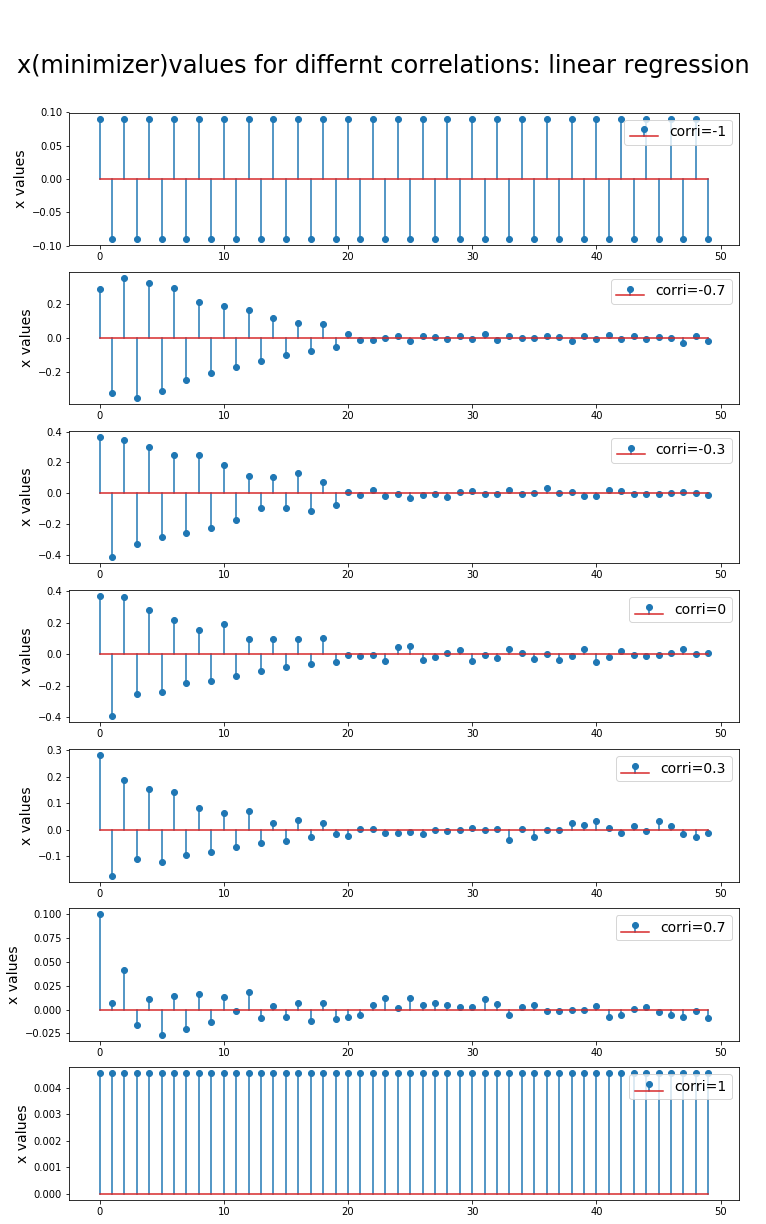

In [44]:
#******************* Q1 ****************************************************

### plot x (minimizer) values for different correlations: linear regression
fig = plt.figure(figsize=(12, 20))
for i in range(nr_corrs):  
    corri = correlations[i]    
    ax = fig.add_subplot(nr_corrs,1,i+1)
    ax.stem(xs[:,i], label="corri="+str(round(corri,2)))    
    ax.legend(loc=1, fontsize=14)
    ax.set_ylabel('x values',fontsize=14)
    
fig.get_axes()[0].annotate('x(minimizer)values for differnt correlations: linear regression',
                           (0.5, 0.94), xycoords='figure fraction', ha='center', 
                            fontsize=24 )
plt.show()   

#### When the absolute level of the correlation is not too high, the x(minimizer) value still resembles the true coefs value. However when the absolute level of the correlation approaches one, the minimizer differ from the coefs value significantly.


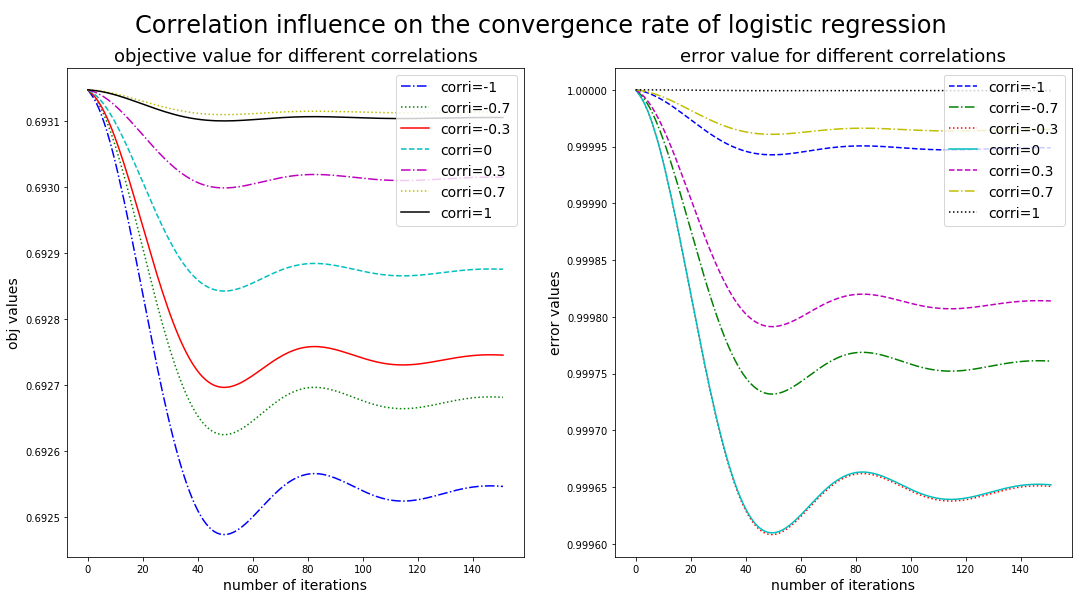

In [45]:
#******************* Q1 ****************************************************
"""Part 2: correlation influence on the logistic regresison (with fista method)"""

# the settings are the same as above, only the number of iterations is reduced to 150
x0 = np.zeros(n_features)
n_iter = 150
s = 1e-2
f = loss_logreg
grad_f = grad_logreg
g = ridge
prox_g = prox_ridge

iteration_ids = np.arange(0, n_iter + 2)
nr_corrs = len(correlations)
nr_f_obj = len(iteration_ids)
f_obj_log = np.zeros(shape=(nr_f_obj,nr_corrs))
xs_log = np.zeros((n_features, nr_corrs))
errors_log = np.zeros((nr_f_obj, nr_corrs))

### calculate new results with different correlations
for i in range(nr_corrs):
    corri = correlations[i]
    A_log, b_log = simu_logreg(coefs, corr=corri)
    L = lip_logreg(A_log)
    step = s / L
    fista_x, fista_objectives, fista_errors = fista(x0, f, grad_f, g, prox_g, step, s, n_iter,
         x_true=coefs, verbose=False)  
    f_obj_log[:,i] = fista_objectives   
    xs_log[:,i] = fista_x
    errors_log[:,i] = fista_errors

 
### plot the objective values for different correlations
fig = plt.figure(figsize=(18., 9.))
plt.subplot(1, 2, 1)
for i in range(nr_corrs):  
    corri = correlations[i]
    plt.plot(iteration_ids, f_obj_log[:,i], next(linecycler),  
             color=next(colors), label="corri="+str(round(corri,2)))
plt.legend(loc=1,fontsize=14)
plt.xlabel('number of iterations',fontsize=14)
plt.ylabel('obj values', fontsize=14)
plt.title('objective value for different correlations',fontsize=18)


### plot the error value for differnt correlations
plt.subplot(1, 2, 2)
for i in range(nr_corrs):  
    corri = correlations[i]
    plt.plot(iteration_ids, errors_log[:,i],next(linecycler),color=next(colors),
             label="corri="+str(round(corri,2)))
plt.legend(loc=1, fontsize=14)
plt.xlabel('number of iterations', fontsize=14)
plt.ylabel('error values',fontsize=14)
plt.title('error value for different correlations', fontsize=18)
fig.get_axes()[0].annotate('Correlation influence on the convergence rate of logistic regression',
                           (0.5, 0.945), xycoords='figure fraction', ha='center', 
                            fontsize=24 )
plt.show() 


#### Clearly, from the picture we see that for the fista method for logistic regression,  the higher the correlation, the faster the covergence.

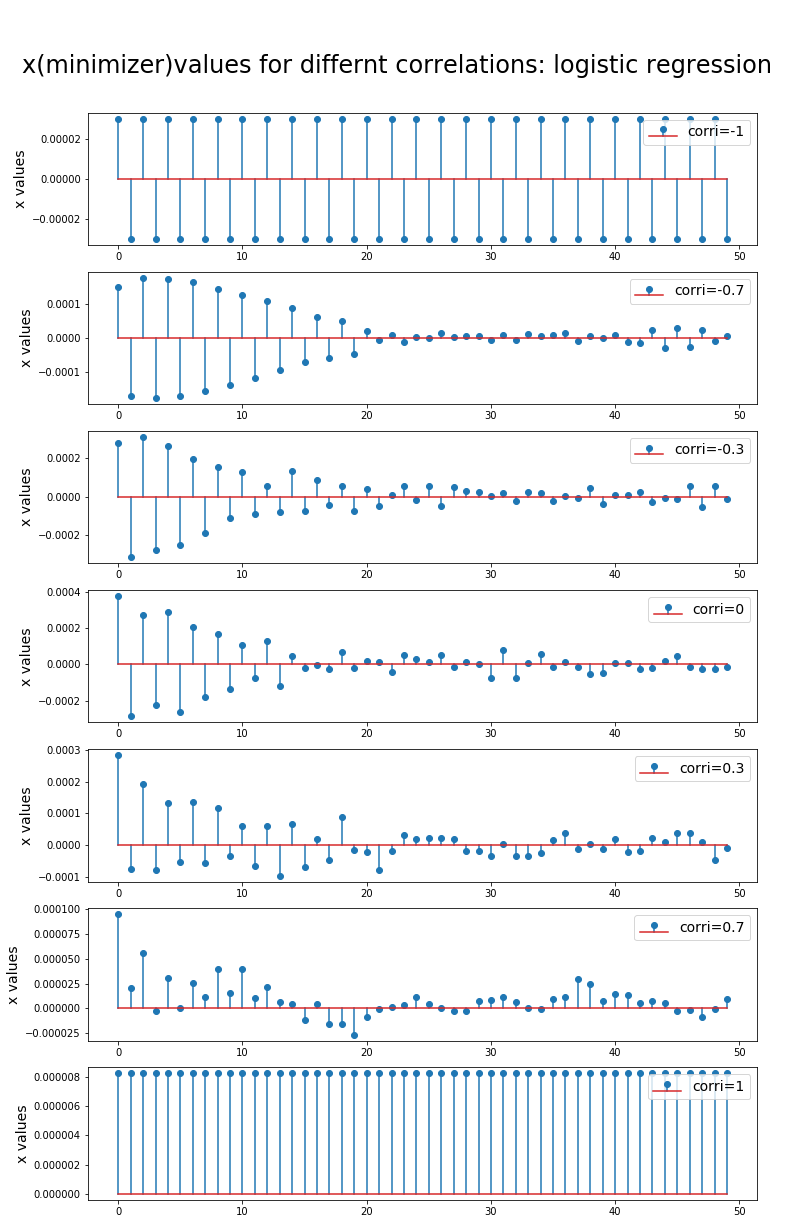

In [46]:
#******************* Q1 ****************************************************
### plot x (minimizer) values for different correlations: logistic regression
fig = plt.figure(figsize=(12, 20))
for i in range(nr_corrs):  
    corri = correlations[i]    
    ax = fig.add_subplot(nr_corrs,1,i+1)
    ax.stem(xs_log[:,i], label="corri="+str(round(corri,2)))    
    ax.legend(loc=1, fontsize=14)
    ax.set_ylabel('x values',fontsize=14)
    
fig.get_axes()[0].annotate('x(minimizer)values for differnt correlations: logistic regression',
                           (0.5, 0.94), xycoords='figure fraction', ha='center', 
                            fontsize=24 )
plt.show()   

#### Commmet for Q1 (study the influence of the correlation ): 
For logistic regression,  when the absolute level of the correlation is not too high, the x(minimizer) value still resembles the true coefs value. However when the absolute level of the correlation approaches one, the minimizer differ from the coefs value significantly.

Togeter with the figures before, clearly, for both linear and logistic regression, the smaller the correlation, the faster the convergence!

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    </ul>
</div>
This will be referred as Q2!

/home/xiang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars


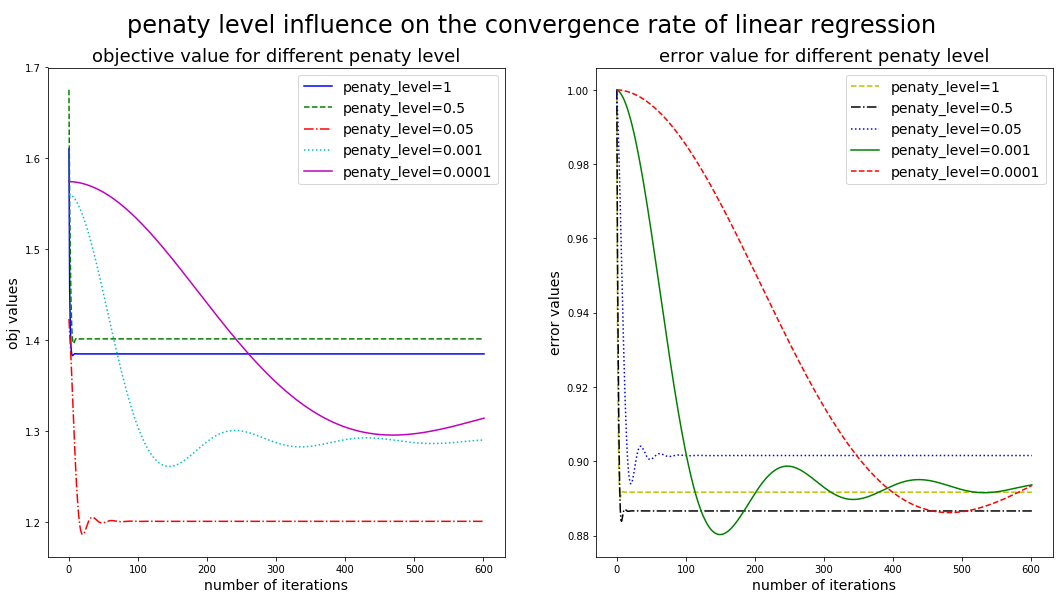

In [47]:
# ********************************** Q2 ************************************************
""" the level of ridge penalization on the performance of the optimization algorithms"""
""" For linear regression, fista method """

from itertools import cycle
import itertools
lines = ["-","--","-.",":"]
linecycler = cycle(lines)
colors = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

# we test the level of ridge penalizaiton with seven differnt values
s_levels = [10, 5, 1, 0.5, 0.05, 1e-3, 1e-4]
x0 = np.zeros(n_features)
n_iter = 600

f = loss_linreg
grad_f = grad_linreg
g = ridge
prox_g = prox_ridge

iteration_ids = np.arange(0, n_iter + 2)
nr_tests = len(s_levels)
nr_f_obj = len(iteration_ids)
f_obj = np.zeros(shape=(nr_f_obj,nr_corrs))
xs = np.zeros((n_features, nr_tests))
errors = np.zeros((nr_f_obj, nr_tests))

### calculate new results with different correlations
for i in range(nr_tests):
    s = s_levels[i]
    A_lr, b_lr = simu_linreg(coefs)
    L = lip_linreg(A_lr)
    step = s / L
    fista_x, fista_objectives, fista_errors = fista(x0, f, grad_f, g, prox_g, step, s, n_iter,
         x_true=coefs, verbose=False)  
    f_obj[:,i] = fista_objectives   
    xs[:,i] = fista_x
    errors[:,i] = fista_errors

 
### plot the objective values for different penalty level
fig = plt.figure(figsize=(18., 9.))
plt.subplot(1, 2, 1)
for i in range(2,nr_tests):  
    s = s_levels[i]
    plt.plot(iteration_ids, f_obj[:,i], next(linecycler),  
             color=next(colors), label="penaty_level="+str(s))
plt.legend(loc=1,fontsize=14)
plt.xlabel('number of iterations',fontsize=14)
plt.ylabel('obj values', fontsize=14)
plt.title('objective value for different penaty level',fontsize=18)
#plt.ylim([0, ])

### plot the error value for differnt penalty level
plt.subplot(1, 2, 2)
for i in range(2, nr_tests):  
    s = s_levels[i]
    plt.plot(iteration_ids, errors[:,i],next(linecycler),color=next(colors),
             label="penaty_level="+str(s))
plt.legend(loc=1, fontsize=14)
plt.xlabel('number of iterations', fontsize=14)
plt.ylabel('error values',fontsize=14)
plt.title('error value for different penaty level', fontsize=18)
fig.get_axes()[0].annotate('penaty level influence on the convergence rate of linear regression',
                           (0.5, 0.945), xycoords='figure fraction', ha='center', 
                            fontsize=24 )
plt.show() 


********************************** Q2 ************************************************

We only plot the when penalty level is smaller than one. For the case when the penaty level is greater than one,  the higher the number, the more meanningless the result becomes. And as the figure above shows, the smaller the penaty, the smaller the error becomes and the more accurate the result is. However when the penaty level decreases, the number of iterations required for achieving covergence increases. 

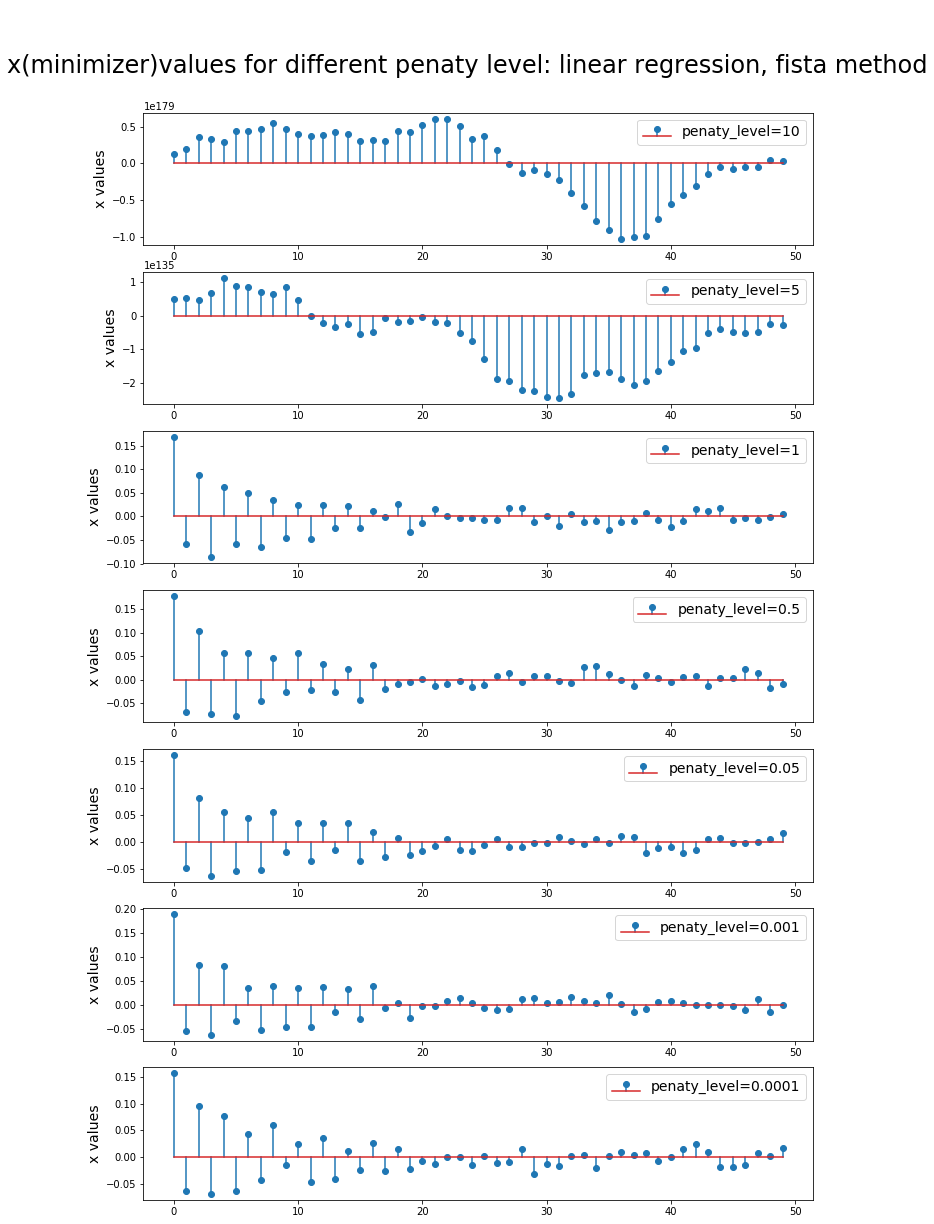

In [48]:
# ********************************** Q2 ************************************************
### plot x (minimizer) values for different correlations: linear regression
fig = plt.figure(figsize=(12, 20))
for i in range(nr_tests):  
    si = s_levels[i]    
    ax = fig.add_subplot(nr_tests,1,i+1)
    ax.stem(xs[:,i], label="penaty_level="+str(si))    
    ax.legend(loc=1, fontsize=14)
    ax.set_ylabel('x values',fontsize=14)
    
fig.get_axes()[0].annotate('x(minimizer)values for different penaty level: linear regression, fista method',
                           (0.5, 0.94), xycoords='figure fraction', ha='center', 
                            fontsize=24 )
plt.show()  

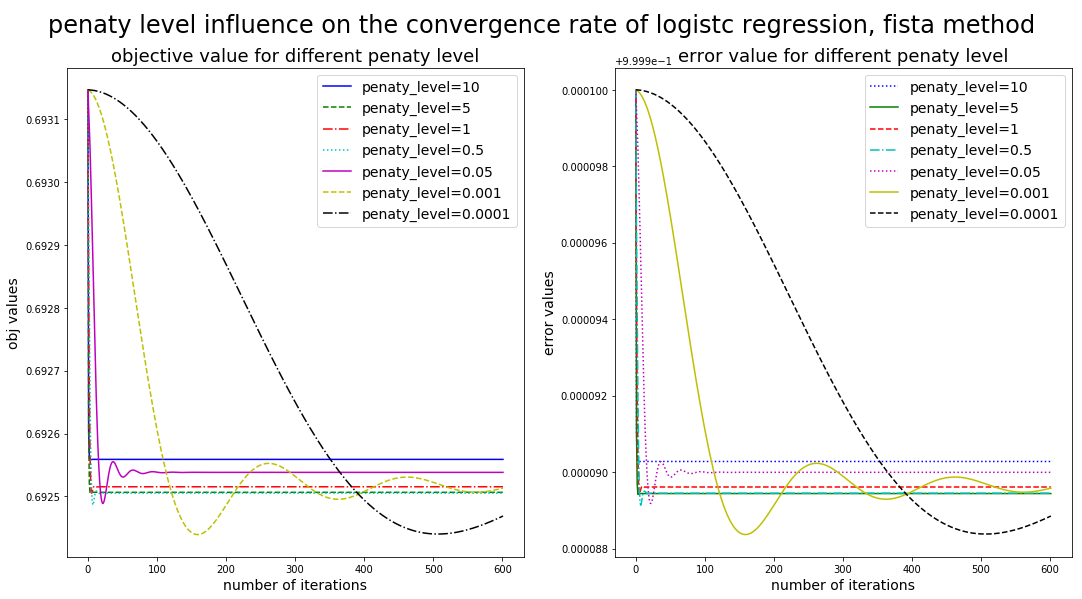

In [49]:
# ********************************** Q2 ************************************************
""" the level of ridge penalization on the performance of the optimization algorithms"""
""" For logistic regression, fista method """

from itertools import cycle
import itertools
lines = ["-","--","-.",":"]
linecycler = cycle(lines)
colors = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

# we test the level of ridge penalizaiton with seven differnt values
s_levels = [10, 5, 1, 0.5, 0.05, 1e-3, 1e-4]
x0 = np.zeros(n_features)
n_iter = 600

f = loss_logreg
grad_f = grad_logreg
g = ridge
prox_g = prox_ridge

iteration_ids = np.arange(0, n_iter + 2)
nr_tests = len(s_levels)
nr_f_obj = len(iteration_ids)
f_obj = np.zeros(shape=(nr_f_obj,nr_corrs))
xs = np.zeros((n_features, nr_tests))
errors = np.zeros((nr_f_obj, nr_tests))

np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
### calculate new results with different correlations
for i in range(nr_tests):
    s = s_levels[i]
    A_lr, b_lr = simu_logreg(coefs)
    L = lip_logreg(A_lr)
    step = s / L
    fista_x, fista_objectives, fista_errors = fista(x0, f, grad_f, g, prox_g, step, s, n_iter,
         x_true=coefs, verbose=False)  
    f_obj[:,i] = fista_objectives 
    #print ( fista_x, '\n')    
    #print (fista_objectives , '\n')
    xs[:,i] = fista_x
    errors[:,i] = fista_errors

 
### plot the objective values for different penalty level
fig = plt.figure(figsize=(18., 9.))
plt.subplot(1, 2, 1)
for i in range(nr_tests):  
    s = s_levels[i]
    plt.plot(iteration_ids, f_obj[:,i], next(linecycler),  
             color=next(colors), label="penaty_level="+str(s))
plt.legend(loc=1,fontsize=14)
plt.xlabel('number of iterations',fontsize=14)
plt.ylabel('obj values', fontsize=14)
plt.title('objective value for different penaty level',fontsize=18)
#plt.ylim([0, ])

### plot the error value for differnt penalty level
plt.subplot(1, 2, 2)
for i in range(nr_tests):  
    s = s_levels[i]
    plt.plot(iteration_ids, errors[:,i],next(linecycler),color=next(colors),
             label="penaty_level="+str(s))
plt.legend(loc=1, fontsize=14)
plt.xlabel('number of iterations', fontsize=14)
plt.ylabel('error values',fontsize=14)
plt.title('error value for different penaty level', fontsize=18)
fig.get_axes()[0].annotate('penaty level influence on the convergence rate of logistc regression, fista method',
                           (0.5, 0.945), xycoords='figure fraction', ha='center', 
                            fontsize=24 )
plt.show() 


********************************** Q2 ************************************************

On first sight, it seems that the smaller the penalty, the more accurate result and the slower the convergence.  However, if we pay attention to the y-lable of each graph, we could see that the objective values and error values for differnt penaty levels (differing in very large scale) are very close. We could basically conclude that the penalty level does not have much influence on teh convergence for the logistic regression.

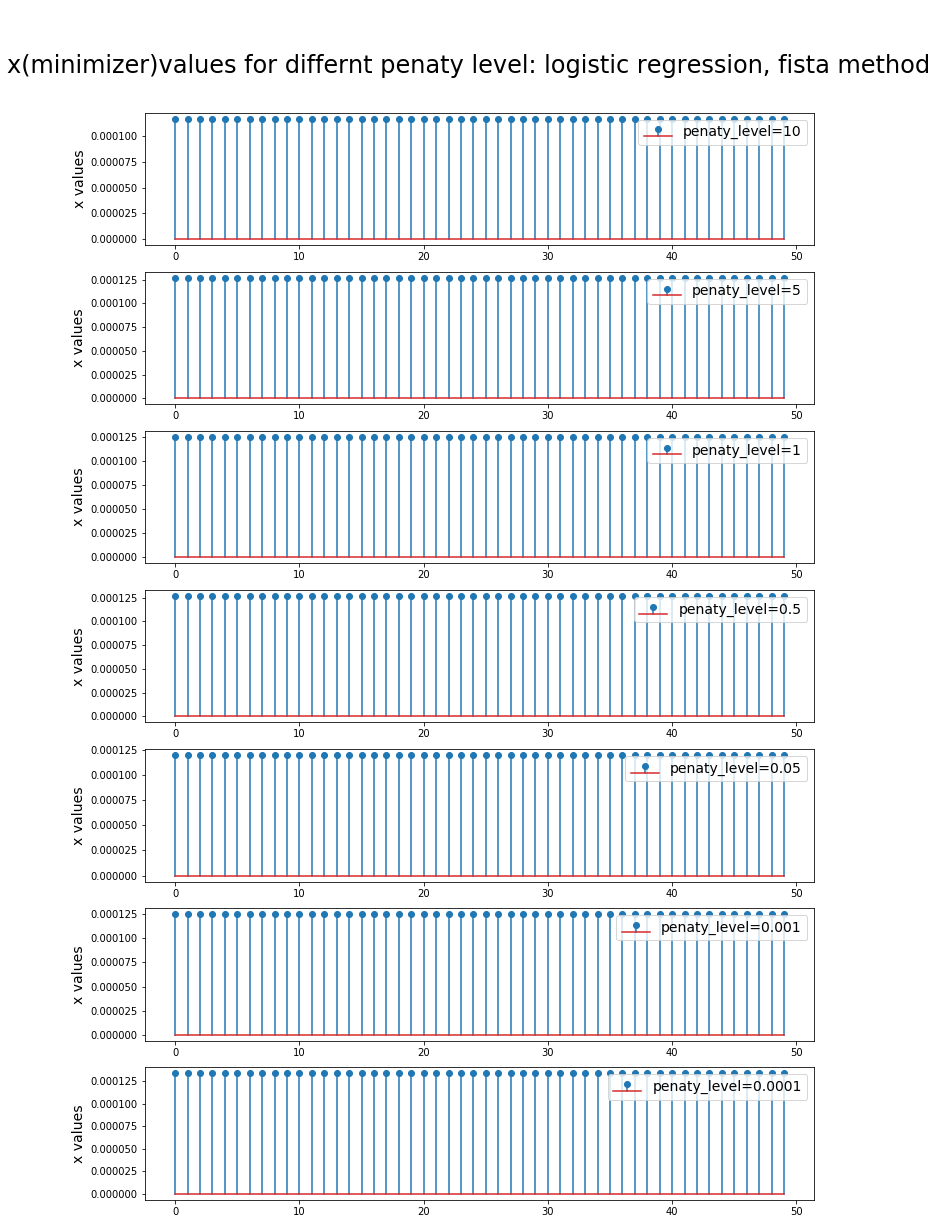

In [50]:
#********************************* Q2 ****************************************
### plot x (minimizer) values for different correlations: logistic regression
fig = plt.figure(figsize=(12, 20))
for i in range(nr_tests):  
    si = s_levels[i]    
    ax = fig.add_subplot(nr_tests,1,i+1)
    ax.stem(xs[:,i], label="penaty_level="+str(si))    
    ax.legend(loc=1, fontsize=14)
    ax.set_ylabel('x values',fontsize=14)
    
fig.get_axes()[0].annotate('x(minimizer)values for differnt penaty level: logistic regression, fista method',
                           (0.5, 0.94), xycoords='figure fraction', ha='center', 
                            fontsize=24 )
plt.show()  

# Comment for Q2 (the influence of the level of ridge penalization on the performance)

Again, the x(minimizer) value are almost identical and almost close to zerofor different pentaly level. This confirms our conclusion that penalty level does not affect the convergence of logistic regression.

In summary, penalty level plays a significant role in linear regression, but not so much in logistic regression.


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>
This will be referred as Q3!

In [51]:
#*********************************** Q3 *******************************************
"""In linear regression and logistic regression, compare the performance of the 
optimization algorithms for ridge and lasso penalizations. """

x0 = np.zeros(n_features)
s = 1e-2
n_iter = 300
nr_tests = 4
iteration_ids = np.arange(0, n_iter + 2)
nr_f_obj = len(iteration_ids)

f_obj = np.zeros(shape=(nr_f_obj,nr_tests))
xs = np.zeros((n_features, nr_tests))
errors = np.zeros((nr_f_obj, nr_tests))

# calculate for linear regression
f = loss_linreg
grad_f = grad_linreg
A_lr, b_lr = simu_linreg(coefs)
L = lip_linreg(A_lr)
step = s / L

# calculate linear regression with ridge
g = ridge
prox_g = prox_ridge
lin_ridge_x, lin_ridge_objectives, lin_ridge_errors = fista(x0, f, grad_f, g, prox_g, step, s, n_iter,
         x_true=coefs, verbose=False)  
xs[:,0] = lin_ridge_x
f_obj[:,0] = lin_ridge_objectives
errors[:,0] = lin_ridge_errors

# calculate linear regression with lasso
g = lasso
prox_g = prox_lasso
lin_lasso_x, lin_lasso_objectives, lin_lasso_errors = fista(x0, f, grad_f, g, prox_g, step, s, n_iter,
         x_true=coefs, verbose=False)  


xs[:,1] = lin_lasso_x
f_obj[:,1] = lin_lasso_objectives
errors[:,1] = lin_lasso_errors



# calculate for logistic regression
f = loss_logreg
grad_f = grad_logreg
A_log, b_log = simu_logreg(coefs)
L = lip_logreg(A_log)
step = s / L

# calculate  logistic regression with ridge
g = ridge
prox_g = prox_ridge
log_ridge_x, log_ridge_objectives, log_ridge_errors = fista(x0, f, grad_f, g, prox_g, step, s, n_iter,
         x_true=coefs, verbose=False)  

xs[:,2] = log_ridge_x
f_obj[:,2] = log_ridge_objectives
errors[:,2] = log_ridge_errors


# calculate  logistic regression with lasso
g = lasso
prox_g = prox_lasso
log_lasso_x, log_lasso_objectives, log_lasso_errors = fista(x0, f, grad_f, g, prox_g, step, s, n_iter,
         x_true=coefs, verbose=False)  

xs[:,3] = log_lasso_x
f_obj[:,3] = log_lasso_objectives
errors[:,3] = log_lasso_errors



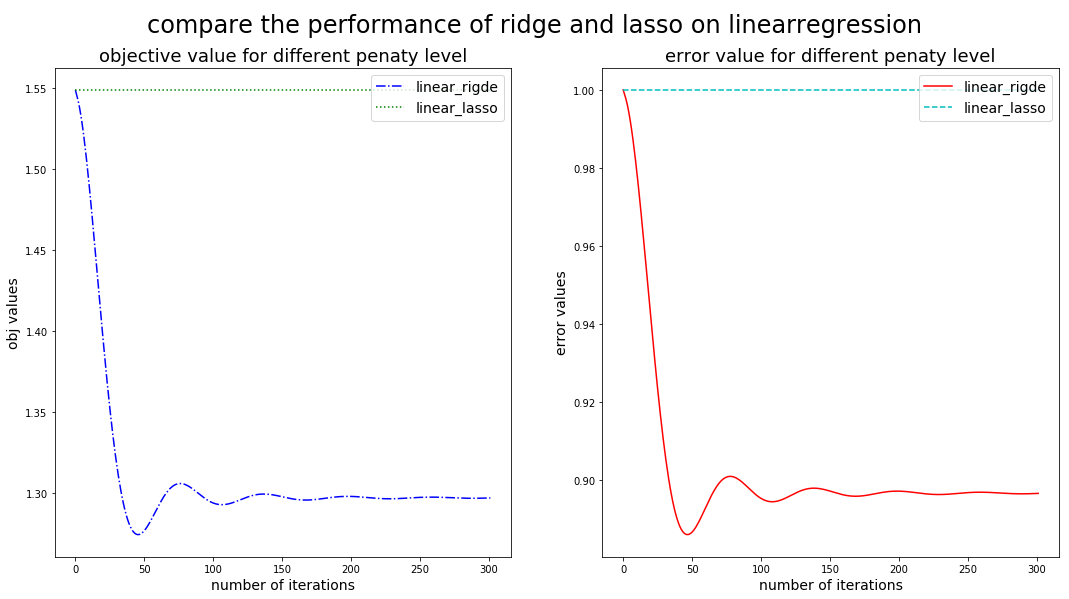

In [52]:
labels = ['linear_rigde', 'linear_lasso', 'log_ridge', 'log_lasso']

fig = plt.figure(figsize=(18., 9.))
plt.subplot(1, 2, 1)
for i in range(2):  
    plt.plot(iteration_ids, f_obj[:,i], next(linecycler),  
             color=next(colors), label=labels[i])
plt.legend(loc=1,fontsize=14)
plt.xlabel('number of iterations',fontsize=14)
plt.ylabel('obj values', fontsize=14)
plt.title('objective value for different penaty level',fontsize=18)
#plt.ylim([0, ])

### plot the error value for differnt penalty level
plt.subplot(1, 2, 2)
for i in range(2):  
    plt.plot(iteration_ids, errors[:,i],next(linecycler),color=next(colors),
             label=labels[i])
plt.legend(loc=1, fontsize=14)
plt.xlabel('number of iterations', fontsize=14)
plt.ylabel('error values',fontsize=14)
plt.title('error value for different penaty level', fontsize=18)
fig.get_axes()[0].annotate('compare the performance of ridge and lasso on linearregression',
                           (0.5, 0.945), xycoords='figure fraction', ha='center', 
                            fontsize=24 )
plt.show() 

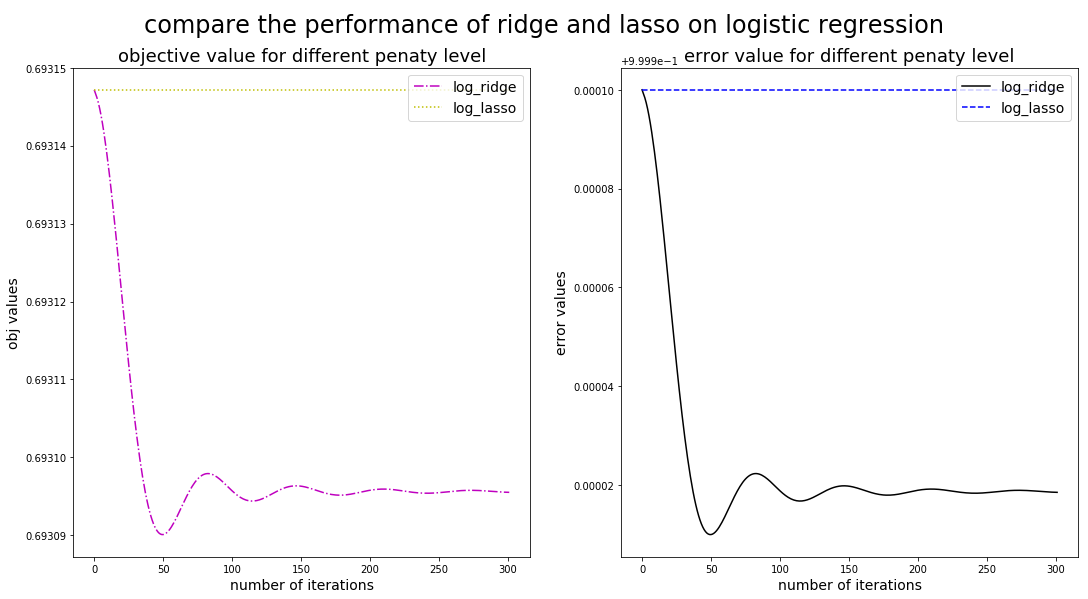

In [53]:
labels = ['linear_ridge', 'linear_lasso', 'log_ridge', 'log_lasso']

fig = plt.figure(figsize=(18., 9.))
plt.subplot(1, 2, 1)
for i in range(2, nr_tests):  
    plt.plot(iteration_ids, f_obj[:,i], next(linecycler),  
             color=next(colors), label=labels[i])
plt.legend(loc=1,fontsize=14)
plt.xlabel('number of iterations',fontsize=14)
plt.ylabel('obj values', fontsize=14)
plt.title('objective value for different penaty level',fontsize=18)
#plt.ylim([0, ])

### plot the error value for differnt penalty level
plt.subplot(1, 2, 2)
for i in range(2, nr_tests):  
    plt.plot(iteration_ids, errors[:,i],next(linecycler),color=next(colors),
             label=labels[i])
plt.legend(loc=1, fontsize=14)
plt.xlabel('number of iterations', fontsize=14)
plt.ylabel('error values',fontsize=14)
plt.title('error value for different penaty level', fontsize=18)
fig.get_axes()[0].annotate('compare the performance of ridge and lasso on logistic regression',
                           (0.5, 0.945), xycoords='figure fraction', ha='center', 
                            fontsize=24 )
plt.show() 

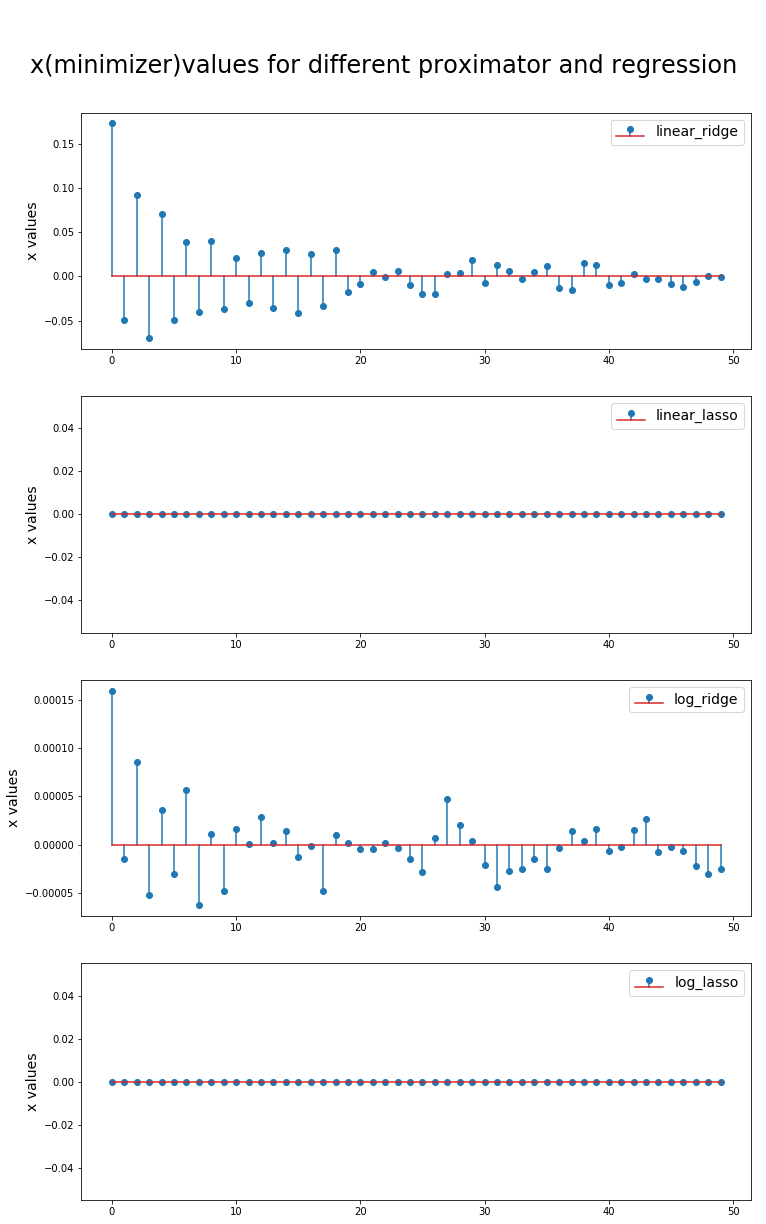

In [54]:
fig = plt.figure(figsize=(12, 20))
for i in range(nr_tests):  
    si = s_levels[i]    
    ax = fig.add_subplot(nr_tests,1,i+1)
    ax.stem(xs[:,i], label=labels[i])    
    ax.legend(loc=1, fontsize=14)
    ax.set_ylabel('x values',fontsize=14)
    
fig.get_axes()[0].annotate('x(minimizer)values for different proximator and regression',
                           (0.5, 0.94), xycoords='figure fraction', ha='center', 
                            fontsize=24 )
plt.show()  

## Algorithms comparison and numerical experiments

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>